## <목욕비누(bathsoap) 구매자 구매액 회귀모델>
* 구매자 데이터 분석을 통해서 브랜드에 대한 고객 충성도 등을 파악해서 광고 프로모션과 같은 판촉을 위한 자료로 사용가능

In [76]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import skew
from tqdm.notebook import tqdm  # 진행상태를 볼 수 있는 모듈

%matplotlib inline

sns.distributions._has_statsmodels = False # seaborn 그래프 오류 해결 (Selected KDE bandwidth is 0. Cannot estiamte density.)

# 패키지, 모듈 불러오기

In [77]:
bathsoap_df = pd.read_csv('BathSoapHousehold.csv')
bathsoap_df

# 총 600가구 데이터(행), 변수 46개

,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence Index,No. of Brands,Brand Runs,Total Volume,No. of Trans,Value,Trans / Brand Runs,Vol/Tran,Avg. Price,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,"Br. Cd. 57, 144",Br. Cd. 55,Br. Cd. 272,Br. Cd. 286,Br. Cd. 24,Br. Cd. 481,Br. Cd. 352,Br. Cd. 5,Others 999,Pr Cat 1,Pr Cat 2,Pr Cat 3,Pr Cat 4,PropCat 5,PropCat 6,PropCat 7,PropCat 8,PropCat 9,PropCat 10,PropCat 11,PropCat 12,PropCat 13,PropCat 14,PropCat 15
0,1010010,4,3,10,1,4,4,2,4,1,2,3,17,8025,24,818.00,1.41,334.38,10.19,1.000000,0.000000,0.000000,0.376947,0.130841,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.492212,0.233645,0.560748,0.130841,0.074766,0.501558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028037,0.000000,0.130841,0.339564
1,1010020,3,2,10,2,2,4,4,2,1,19,5,25,13975,40,1681.50,1.60,349.38,12.03,0.887299,0.096601,0.016100,0.021467,0.075134,0.000000,0.000000,0.000000,0.059034,0.0,0.144902,0.699463,0.293381,0.547406,0.094812,0.064401,0.456172,0.347048,0.026834,0.016100,0.014311,0.000000,0.059034,0.000000,0.000000,0.080501,0.000000
2,1014020,2,3,10,2,4,5,6,4,1,23,5,37,23100,63,1950.00,1.70,366.67,8.44,0.941558,0.019481,0.038961,0.025974,0.545455,0.000000,0.030303,0.000000,0.000000,0.0,0.019481,0.378788,0.120130,0.318182,0.561688,0.000000,0.244589,0.121212,0.033550,0.010823,0.008658,0.000000,0.000000,0.016234,0.000000,0.561688,0.003247
3,1014030,4,0,0,0,4,0,0,5,0,0,2,4,1500,4,114.00,1.00,375.00,7.60,1.000000,0.000000,0.000000,0.400000,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.600000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000
4,1014190,4,1,10,2,3,4,4,3,1,10,3,6,8300,13,591.00,2.17,638.46,7.12,0.614458,0.144578,0.240964,0.048193,0.144578,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.807229,0.000000,0.048193,0.144578,0.807229,0.807229,0.000000,0.000000,0.048193,0.000000,0.000000,0.000000,0.000000,0.000000,0.144578,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1167090,2,3,10,2,4,5,5,4,1,15,3,5,9025,22,1218.00,4.40,410.23,13.50,0.775623,0.224377,0.000000,0.044321,0.000000,0.000000,0.000000,0.000000,0.897507,0.0,0.000000,0.058172,0.058172,0.941828,0.000000,0.000000,0.077562,0.000000,0.000000,0.000000,0.000000,0.024931,0.897507,0.000000,0.000000,0.000000,0.000000
596,1167230,3,3,10,2,3,5,4,4,1,29,5,23,5050,28,851.00,1.22,180.36,16.85,0.925743,0.074257,0.000000,0.000000,0.000000,0.089109,0.039604,0.089109,0.000000,0.0,0.103960,0.678218,0.534653,0.366337,0.000000,0.099010,0.168317,0.430693,0.074257,0.148515,0.000000,0.039604,0.000000,0.000000,0.089109,0.000000,0.049505
597,1167340,3,3,17,2,4,4,9,4,1,13,4,19,29100,25,3302.75,1.32,1164.00,11.35,1.000000,0.000000,0.000000,0.246564,0.180412,0.015464,0.000000,0.000000,0.000000,0.0,0.000000,0.557560,0.170103,0.649485,0.180412,0.000000,0.622852,0.127148,0.000000,0.030928,0.000000,0.038660,0.000000,0.000000,0.000000,0.180412,0.000000
598,1167350,2,1,4,2,4,5,2,4,2,20,3,15,5500,19,460.00,1.27,289.47,8.36,0.759091,0.186364,0.054545,0.000000,0.109091,0.000000,0.000000,0.027273,0.000000,0.0,0.000000,0.863636,0.136364,0.509091,0.209091,0.145455,0.690909,0.145455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027273,0.136364,0.000000


No. of Trans 총 거래 횟수

* 한 행이 1가구(가계 데이터)이고 건당 거래(거래 데이터)를 나타냄
* 구매자의 구매행동 추적을 하기 위한 데이터 세트임
* Value(구매액 합계)가 종속변수

In [78]:
cols = bathsoap_df.columns.tolist()
value = cols[15]
del cols[15]
cols.insert(0,value)
bathsoap_df = bathsoap_df[cols]

# target 값 맨 앞으로

bathsoap_df_copy = bathsoap_df.copy()
bathsoap_df_copy2 = bathsoap_df.copy()
bathsoap_df

# orginal 데이터프레임 변수

,Value,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence Index,No. of Brands,Brand Runs,Total Volume,No. of Trans,Trans / Brand Runs,Vol/Tran,Avg. Price,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,"Br. Cd. 57, 144",Br. Cd. 55,Br. Cd. 272,Br. Cd. 286,Br. Cd. 24,Br. Cd. 481,Br. Cd. 352,Br. Cd. 5,Others 999,Pr Cat 1,Pr Cat 2,Pr Cat 3,Pr Cat 4,PropCat 5,PropCat 6,PropCat 7,PropCat 8,PropCat 9,PropCat 10,PropCat 11,PropCat 12,PropCat 13,PropCat 14,PropCat 15
0,818.00,1010010,4,3,10,1,4,4,2,4,1,2,3,17,8025,24,1.41,334.38,10.19,1.000000,0.000000,0.000000,0.376947,0.130841,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.492212,0.233645,0.560748,0.130841,0.074766,0.501558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028037,0.000000,0.130841,0.339564
1,1681.50,1010020,3,2,10,2,2,4,4,2,1,19,5,25,13975,40,1.60,349.38,12.03,0.887299,0.096601,0.016100,0.021467,0.075134,0.000000,0.000000,0.000000,0.059034,0.0,0.144902,0.699463,0.293381,0.547406,0.094812,0.064401,0.456172,0.347048,0.026834,0.016100,0.014311,0.000000,0.059034,0.000000,0.000000,0.080501,0.000000
2,1950.00,1014020,2,3,10,2,4,5,6,4,1,23,5,37,23100,63,1.70,366.67,8.44,0.941558,0.019481,0.038961,0.025974,0.545455,0.000000,0.030303,0.000000,0.000000,0.0,0.019481,0.378788,0.120130,0.318182,0.561688,0.000000,0.244589,0.121212,0.033550,0.010823,0.008658,0.000000,0.000000,0.016234,0.000000,0.561688,0.003247
3,114.00,1014030,4,0,0,0,4,0,0,5,0,0,2,4,1500,4,1.00,375.00,7.60,1.000000,0.000000,0.000000,0.400000,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.600000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000
4,591.00,1014190,4,1,10,2,3,4,4,3,1,10,3,6,8300,13,2.17,638.46,7.12,0.614458,0.144578,0.240964,0.048193,0.144578,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.807229,0.000000,0.048193,0.144578,0.807229,0.807229,0.000000,0.000000,0.048193,0.000000,0.000000,0.000000,0.000000,0.000000,0.144578,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1218.00,1167090,2,3,10,2,4,5,5,4,1,15,3,5,9025,22,4.40,410.23,13.50,0.775623,0.224377,0.000000,0.044321,0.000000,0.000000,0.000000,0.000000,0.897507,0.0,0.000000,0.058172,0.058172,0.941828,0.000000,0.000000,0.077562,0.000000,0.000000,0.000000,0.000000,0.024931,0.897507,0.000000,0.000000,0.000000,0.000000
596,851.00,1167230,3,3,10,2,3,5,4,4,1,29,5,23,5050,28,1.22,180.36,16.85,0.925743,0.074257,0.000000,0.000000,0.000000,0.089109,0.039604,0.089109,0.000000,0.0,0.103960,0.678218,0.534653,0.366337,0.000000,0.099010,0.168317,0.430693,0.074257,0.148515,0.000000,0.039604,0.000000,0.000000,0.089109,0.000000,0.049505
597,3302.75,1167340,3,3,17,2,4,4,9,4,1,13,4,19,29100,25,1.32,1164.00,11.35,1.000000,0.000000,0.000000,0.246564,0.180412,0.015464,0.000000,0.000000,0.000000,0.0,0.000000,0.557560,0.170103,0.649485,0.180412,0.000000,0.622852,0.127148,0.000000,0.030928,0.000000,0.038660,0.000000,0.000000,0.000000,0.180412,0.000000
598,460.00,1167350,2,1,4,2,4,5,2,4,2,20,3,15,5500,19,1.27,289.47,8.36,0.759091,0.186364,0.054545,0.000000,0.109091,0.000000,0.000000,0.027273,0.000000,0.0,0.000000,0.863636,0.136364,0.509091,0.209091,0.145455,0.690909,0.145455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027273,0.136364,0.000000


* 브랜드 제품 구매 건수, 구매거래건수 차이가 뭘까

-- No. of Trans는 구매가 이루어진 횟수(비누 갯수에 상관없이?), No. of Brands는 구매한 제품 브랜드 종류의 수

#### 비율값 칼럼 처리방식

- Purchase within promotion
- Brandwise purchase
- Price categorywise purchase
- Selling propositionwise purchase

In [79]:
# 방법 1
# 비율 값에 해당하는 칼럼에 모두 100을 곱해줌

bathsoap_df[bathsoap_df.columns[19:]] = np.round(bathsoap_df[bathsoap_df.columns[19:]] * 100, 2)
bathsoap_df

,Value,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence Index,No. of Brands,Brand Runs,Total Volume,No. of Trans,Trans / Brand Runs,Vol/Tran,Avg. Price,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,"Br. Cd. 57, 144",Br. Cd. 55,Br. Cd. 272,Br. Cd. 286,Br. Cd. 24,Br. Cd. 481,Br. Cd. 352,Br. Cd. 5,Others 999,Pr Cat 1,Pr Cat 2,Pr Cat 3,Pr Cat 4,PropCat 5,PropCat 6,PropCat 7,PropCat 8,PropCat 9,PropCat 10,PropCat 11,PropCat 12,PropCat 13,PropCat 14,PropCat 15
0,818.00,1010010,4,3,10,1,4,4,2,4,1,2,3,17,8025,24,1.41,334.38,10.19,100.00,0.00,0.00,37.69,13.08,0.00,0.00,0.00,0.00,0.0,0.00,49.22,23.36,56.07,13.08,7.48,50.16,0.00,0.00,0.00,0.00,0.00,0.00,2.80,0.00,13.08,33.96
1,1681.50,1010020,3,2,10,2,2,4,4,2,1,19,5,25,13975,40,1.60,349.38,12.03,88.73,9.66,1.61,2.15,7.51,0.00,0.00,0.00,5.90,0.0,14.49,69.95,29.34,54.74,9.48,6.44,45.62,34.70,2.68,1.61,1.43,0.00,5.90,0.00,0.00,8.05,0.00
2,1950.00,1014020,2,3,10,2,4,5,6,4,1,23,5,37,23100,63,1.70,366.67,8.44,94.16,1.95,3.90,2.60,54.55,0.00,3.03,0.00,0.00,0.0,1.95,37.88,12.01,31.82,56.17,0.00,24.46,12.12,3.35,1.08,0.87,0.00,0.00,1.62,0.00,56.17,0.32
3,114.00,1014030,4,0,0,0,4,0,0,5,0,0,2,4,1500,4,1.00,375.00,7.60,100.00,0.00,0.00,40.00,60.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,40.00,60.00,0.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,60.00,0.00
4,591.00,1014190,4,1,10,2,3,4,4,3,1,10,3,6,8300,13,2.17,638.46,7.12,61.45,14.46,24.10,4.82,14.46,0.00,0.00,0.00,0.00,0.0,0.00,80.72,0.00,4.82,14.46,80.72,80.72,0.00,0.00,4.82,0.00,0.00,0.00,0.00,0.00,14.46,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1218.00,1167090,2,3,10,2,4,5,5,4,1,15,3,5,9025,22,4.40,410.23,13.50,77.56,22.44,0.00,4.43,0.00,0.00,0.00,0.00,89.75,0.0,0.00,5.82,5.82,94.18,0.00,0.00,7.76,0.00,0.00,0.00,0.00,2.49,89.75,0.00,0.00,0.00,0.00
596,851.00,1167230,3,3,10,2,3,5,4,4,1,29,5,23,5050,28,1.22,180.36,16.85,92.57,7.43,0.00,0.00,0.00,8.91,3.96,8.91,0.00,0.0,10.40,67.82,53.47,36.63,0.00,9.90,16.83,43.07,7.43,14.85,0.00,3.96,0.00,0.00,8.91,0.00,4.95
597,3302.75,1167340,3,3,17,2,4,4,9,4,1,13,4,19,29100,25,1.32,1164.00,11.35,100.00,0.00,0.00,24.66,18.04,1.55,0.00,0.00,0.00,0.0,0.00,55.76,17.01,64.95,18.04,0.00,62.29,12.71,0.00,3.09,0.00,3.87,0.00,0.00,0.00,18.04,0.00
598,460.00,1167350,2,1,4,2,4,5,2,4,2,20,3,15,5500,19,1.27,289.47,8.36,75.91,18.64,5.45,0.00,10.91,0.00,0.00,2.73,0.00,0.0,0.00,86.36,13.64,50.91,20.91,14.55,69.09,14.55,0.00,0.00,0.00,0.00,0.00,0.00,2.73,13.64,0.00


In [80]:
for col in  bathsoap_df_copy2.columns[19:]:
     bathsoap_df_copy2[col] =  bathsoap_df_copy2[col] *  bathsoap_df_copy2['Total Volume']

bathsoap_df_copy2[bathsoap_df_copy.columns[19:]] = np.round(bathsoap_df_copy2[bathsoap_df_copy2.columns[19:]],2)

# bathsoap_df_copy2 카피

In [81]:
# 방법 2 --> 이용하기로 함
# 구매량 비율에 해당하는 칼럼들을 bathsoap_df['Total Volume'](구매량합계) 값으로 다 곱해줘서 비율에 해당하는 특정 구매량을 구하는 것.

for col in  bathsoap_df_copy.columns[19:]:
    bathsoap_df_copy[col] = bathsoap_df_copy[col] * bathsoap_df_copy['Total Volume']

bathsoap_df_copy[bathsoap_df_copy.columns[19:]] = np.round(bathsoap_df_copy[bathsoap_df_copy.columns[19:]],2)
bathsoap_df_copy[bathsoap_df_copy.columns[19:]]

,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,"Br. Cd. 57, 144",Br. Cd. 55,Br. Cd. 272,Br. Cd. 286,Br. Cd. 24,Br. Cd. 481,Br. Cd. 352,Br. Cd. 5,Others 999,Pr Cat 1,Pr Cat 2,Pr Cat 3,Pr Cat 4,PropCat 5,PropCat 6,PropCat 7,PropCat 8,PropCat 9,PropCat 10,PropCat 11,PropCat 12,PropCat 13,PropCat 14,PropCat 15
0,8025.0,0.0,0.0,3025.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,3950.0,1875.0,4500.0,1050.0,600.0,4025.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,1050.0,2725.0
1,12400.0,1350.0,225.0,300.0,1050.0,0.0,0.0,0.0,825.0,0.0,2025.0,9775.0,4100.0,7650.0,1325.0,900.0,6375.0,4850.0,375.0,225.0,200.0,0.0,825.0,0.0,0.0,1125.0,0.0
2,21750.0,450.0,900.0,600.0,12600.0,0.0,700.0,0.0,0.0,0.0,450.0,8750.0,2775.0,7350.0,12975.0,0.0,5650.0,2800.0,775.0,250.0,200.0,0.0,0.0,375.0,0.0,12975.0,75.0
3,1500.0,0.0,0.0,600.0,900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,900.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,0.0
4,5100.0,1200.0,2000.0,400.0,1200.0,0.0,0.0,0.0,0.0,0.0,0.0,6700.0,0.0,400.0,1200.0,6700.0,6700.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0,1200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,7000.0,2025.0,0.0,400.0,0.0,0.0,0.0,0.0,8100.0,0.0,0.0,525.0,525.0,8500.0,0.0,0.0,700.0,0.0,0.0,0.0,0.0,225.0,8100.0,0.0,0.0,0.0,0.0
596,4675.0,375.0,0.0,0.0,0.0,450.0,200.0,450.0,0.0,0.0,525.0,3425.0,2700.0,1850.0,0.0,500.0,850.0,2175.0,375.0,750.0,0.0,200.0,0.0,0.0,450.0,0.0,250.0
597,29100.0,0.0,0.0,7175.0,5250.0,450.0,0.0,0.0,0.0,0.0,0.0,16225.0,4950.0,18900.0,5250.0,0.0,18125.0,3700.0,0.0,900.0,0.0,1125.0,0.0,0.0,0.0,5250.0,0.0
598,4175.0,1025.0,300.0,0.0,600.0,0.0,0.0,150.0,0.0,0.0,0.0,4750.0,750.0,2800.0,1150.0,800.0,3800.0,800.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,750.0,0.0


* ## 데이터 탐색

In [7]:
bathsoap_df.info()

# 변수 모두 수치형 데이터(실수, 정수형)로 구성 
# 모든 변수의 null 값은 일단 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Value                  600 non-null    float64
 1   Member id              600 non-null    int64  
 2   SEC                    600 non-null    int64  
 3   FEH                    600 non-null    int64  
 4   MT                     600 non-null    int64  
 5   SEX                    600 non-null    int64  
 6   AGE                    600 non-null    int64  
 7   EDU                    600 non-null    int64  
 8   HS                     600 non-null    int64  
 9   CHILD                  600 non-null    int64  
 10  CS                     600 non-null    int64  
 11  Affluence Index        600 non-null    int64  
 12  No. of Brands          600 non-null    int64  
 13  Brand Runs             600 non-null    int64  
 14  Total Volume           600 non-null    int64  
 15  No. of

In [8]:
bathsoap_df.describe()

,Value,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence Index,No. of Brands,Brand Runs,Total Volume,No. of Trans,Trans / Brand Runs,Vol/Tran,Avg. Price,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,"Br. Cd. 57, 144",Br. Cd. 55,Br. Cd. 272,Br. Cd. 286,Br. Cd. 24,Br. Cd. 481,Br. Cd. 352,Br. Cd. 5,Others 999,Pr Cat 1,Pr Cat 2,Pr Cat 3,Pr Cat 4,PropCat 5,PropCat 6,PropCat 7,PropCat 8,PropCat 9,PropCat 10,PropCat 11,PropCat 12,PropCat 13,PropCat 14,PropCat 15
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.00000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,1337.386433,1.104188e+06,2.500000,2.048333,8.178333,1.738333,3.213333,4.043333,4.191667,3.233333,0.931667,17.02000,3.636667,15.751667,11914.770000,31.153333,2.617783,415.051217,11.834717,91.300967,5.350117,3.349217,18.382200,12.934850,3.315550,3.394817,1.932067,2.592300,3.423183,1.818650,52.199167,27.903433,49.314267,13.920467,8.861800,45.716417,9.232467,9.690883,8.014767,3.080500,2.024850,2.936783,0.621750,2.493700,13.648133,2.539833
std,883.155463,4.560152e+04,1.118967,1.134964,4.294641,0.648510,0.865489,2.190004,2.300090,1.217110,0.507372,11.41008,1.579709,10.396481,7770.374508,17.427258,2.604683,248.761232,3.742725,11.948865,9.298731,7.198624,23.642771,25.972801,9.095724,11.289113,7.976775,8.936213,12.155876,6.790338,29.732458,28.088468,31.158614,26.803537,19.168584,31.634812,16.633129,19.575979,15.256251,6.281484,7.665499,9.846880,2.631186,9.544709,26.604607,8.759426
min,20.000000,1.010010e+06,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,1.000000,150.000000,1.000000,1.000000,94.430000,5.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,789.562500,1.065295e+06,1.750000,1.000000,4.000000,2.000000,3.000000,3.000000,3.000000,2.000000,1.000000,10.00000,2.000000,8.000000,6825.000000,22.000000,1.420000,250.515000,9.760000,87.857500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.892500,5.667500,20.842500,0.000000,0.000000,15.975000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1216.000000,1.106235e+06,2.500000,3.000000,10.000000,2.000000,3.000000,4.500000,4.000000,4.000000,1.000000,15.00000,3.000000,15.000000,10360.000000,28.000000,1.845000,361.525000,11.250000,95.350000,0.000000,0.000000,8.035000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.510000,18.085000,52.500000,0.000000,0.000000,44.440000,2.015000,1.260000,0.775000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1675.750000,1.148292e+06,3.250000,3.000000,10.000000,2.000000,4.000000,5.000000,5.000000,4.000000,1.000000,24.00000,5.000000,21.000000,15343.750000,40.000000,2.690000,490.890000,13.417500,100.000000,6.820000,4.382500,28.240000,9.487500,1.912500,0.000000,0.000000,0.610000,0.000000,0.952500,77.832500,41.985000,74.755000,12.250000,7.070000,72.000000,10.367500,8.292500,8.635000,3.162500,0.000000,0.772500,0.000000,0.555000,11.837500,0.000000
max,6371.850000,1.167670e+06,4.000000,3.000000,19.000000,2.000000,4.000000,9.000000,15.000000,5.000000,2.000000,53.00000,9.000000,74.000000,50895.000000,138.000000,23.000000,2525.000000,33.330000,100.000000,66.670000,100.000000,100.000000,100.000000,96.360000,100.000000,100.000000,89.750000,99.320000,97.110000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00

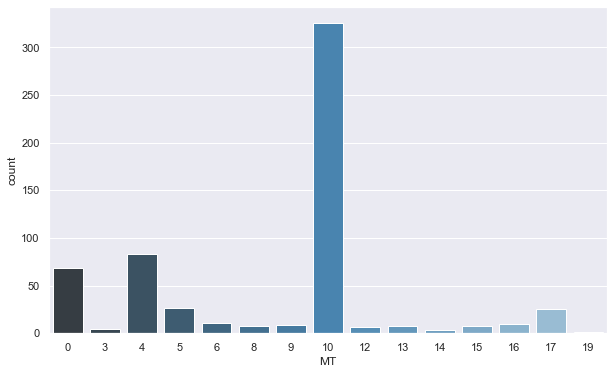

In [9]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(bathsoap_df['MT'], palette="Blues_d")

__삭제할 변수__ : MT (모국어)<br>
→ 카테고리 개수가 너무 많기 때문에 뒤에서 원핫인코딩을 할 때 변수가 너무 많아질 가능성이 있어서

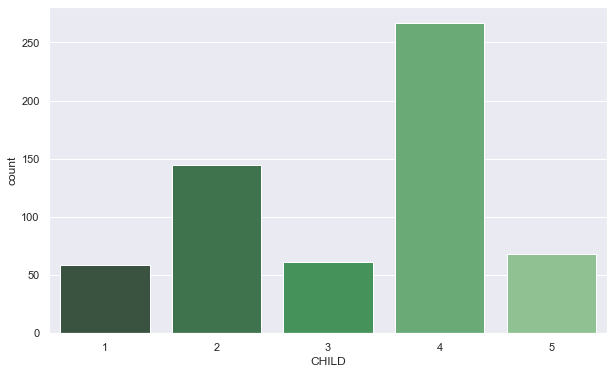

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(bathsoap_df['CHILD'], palette="Greens_d")

__삭제할 변수__ : CHILD (자녀 형태)<br>
→ 변수가 의미하는 바가 뚜렷하지 않음. 자녀의 수인지 아니면 범주형 변수인지가 애매.

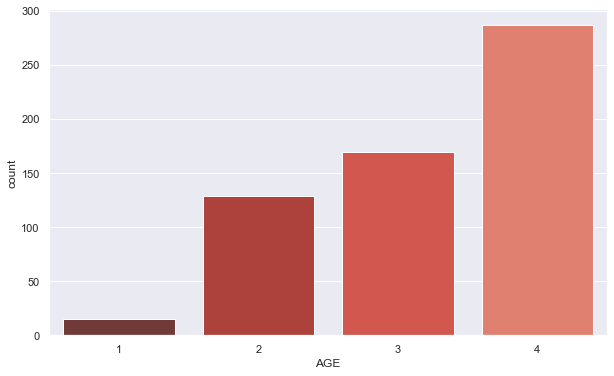

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(bathsoap_df['AGE'], palette="Reds_d")

AGE(연령)에서 1 ~ 4 구간이 정확히 몇 세 ~ 몇 세인지 나와있지 않지만 __원핫인코딩을 하지 않아도 되는 숫자형 카테고리 변수__

* ### 숫자형 카테고리 피처 (숫자크기가 의미가 없는)

  FEH (demographics)	
  CS \
  sex\
CHILD (demographics) ==> 자녀의 수로 범주화한게 아닐 수도 있고 자녀 조합으로 범주화 했으면 범주값은 의미없는 값임

* ### 숫자형 카테고리 피처 (숫자크기가 의미가 있는)
AGE (demographics)
 

* ### 연속형 숫자 피처 

SEC (demographics)
MT (애매함) 
EDU 
HS 
Affluence Index 

No. of Brands (purchase summary)\
Brand Runs 
Total Volume	
No. of Trans
Trans / Brand Runs	
Avg. Price

Pur Vol No Promo - % (purchase within promotion)\
Pur Vol Promo 6 % \
Pur Vol Other Promo %

Br. Cd. 57, 144 (brandwise purchase)\
Br. Cd. 272	
Br. Cd. 286	
Br. Cd. 24	
Br. Cd. 481	
Br. Cd. 352	
Br. Cd. 5	
Others 999	

Pr Cat 1 (price categorywise purchase)\
Pr Cat 2	
Pr Cat 3	
Pr Cat 4

PropCat 5 (selling propositionwise purchase)\
PropCat 6	
PropCat 7	
PropCat 8	
PropCat 9	
PropCat 10	
PropCat 11	
PropCat 12	
PropCat 13	
PropCat 14	
PropCat 15

* 타겟값 + 필요없는 변수 + 숫자형 카테고리피쳐(숫자가 의미없는) 칼럼은 제외하고 lmplot시각화해보기(산점도+회귀선 출력해주는)

* 타겟값에  어느정도 영향을 주는 변수(회귀계수가 어느정도 클 것(양,음방향 포함)으로 예상되는)를 대략적으로 먼저 생각해보면 
* Brand Runs(브랜드 제품 연속 구매 건수), Total Volume(구매량 합계), No. of  Trans(구매거래건수), Vol/Tran(평균 구매량), Avg. Price(평균 구입 가격)      ------양의 방향성


* Pur Vol Promo 6 %(판촉코드 6번에 의한 구매량비율), Pr Cat 3(구매 제의 코드3(Glycerine)의 구매량 비율),Pur Vol Other Promo %(타판촉에 의한 구매량비율)    ---- 음의 방향성


* regplot은 hue 옵션 적용안됨
* lmplot은 ax 옵션이 없음 

###  방법 2 bathsoap_df_copy(모든 구매량 비율에 Total volume(구매량 합계)  곱한 데이터프레임)

In [82]:
bathsoap_feature_list = list(bathsoap_df_copy.columns) 
bathsoap_feature_list.remove('Value')  
bathsoap_feature_list.remove('Member id')    
bathsoap_feature_list.remove('FEH') 
bathsoap_feature_list.remove('CS') 
bathsoap_feature_list.remove('SEX') 
bathsoap_feature_list.remove('CHILD') 

# bathsoap_df_copy(방법 2) 데이터프레임에 대한 처리

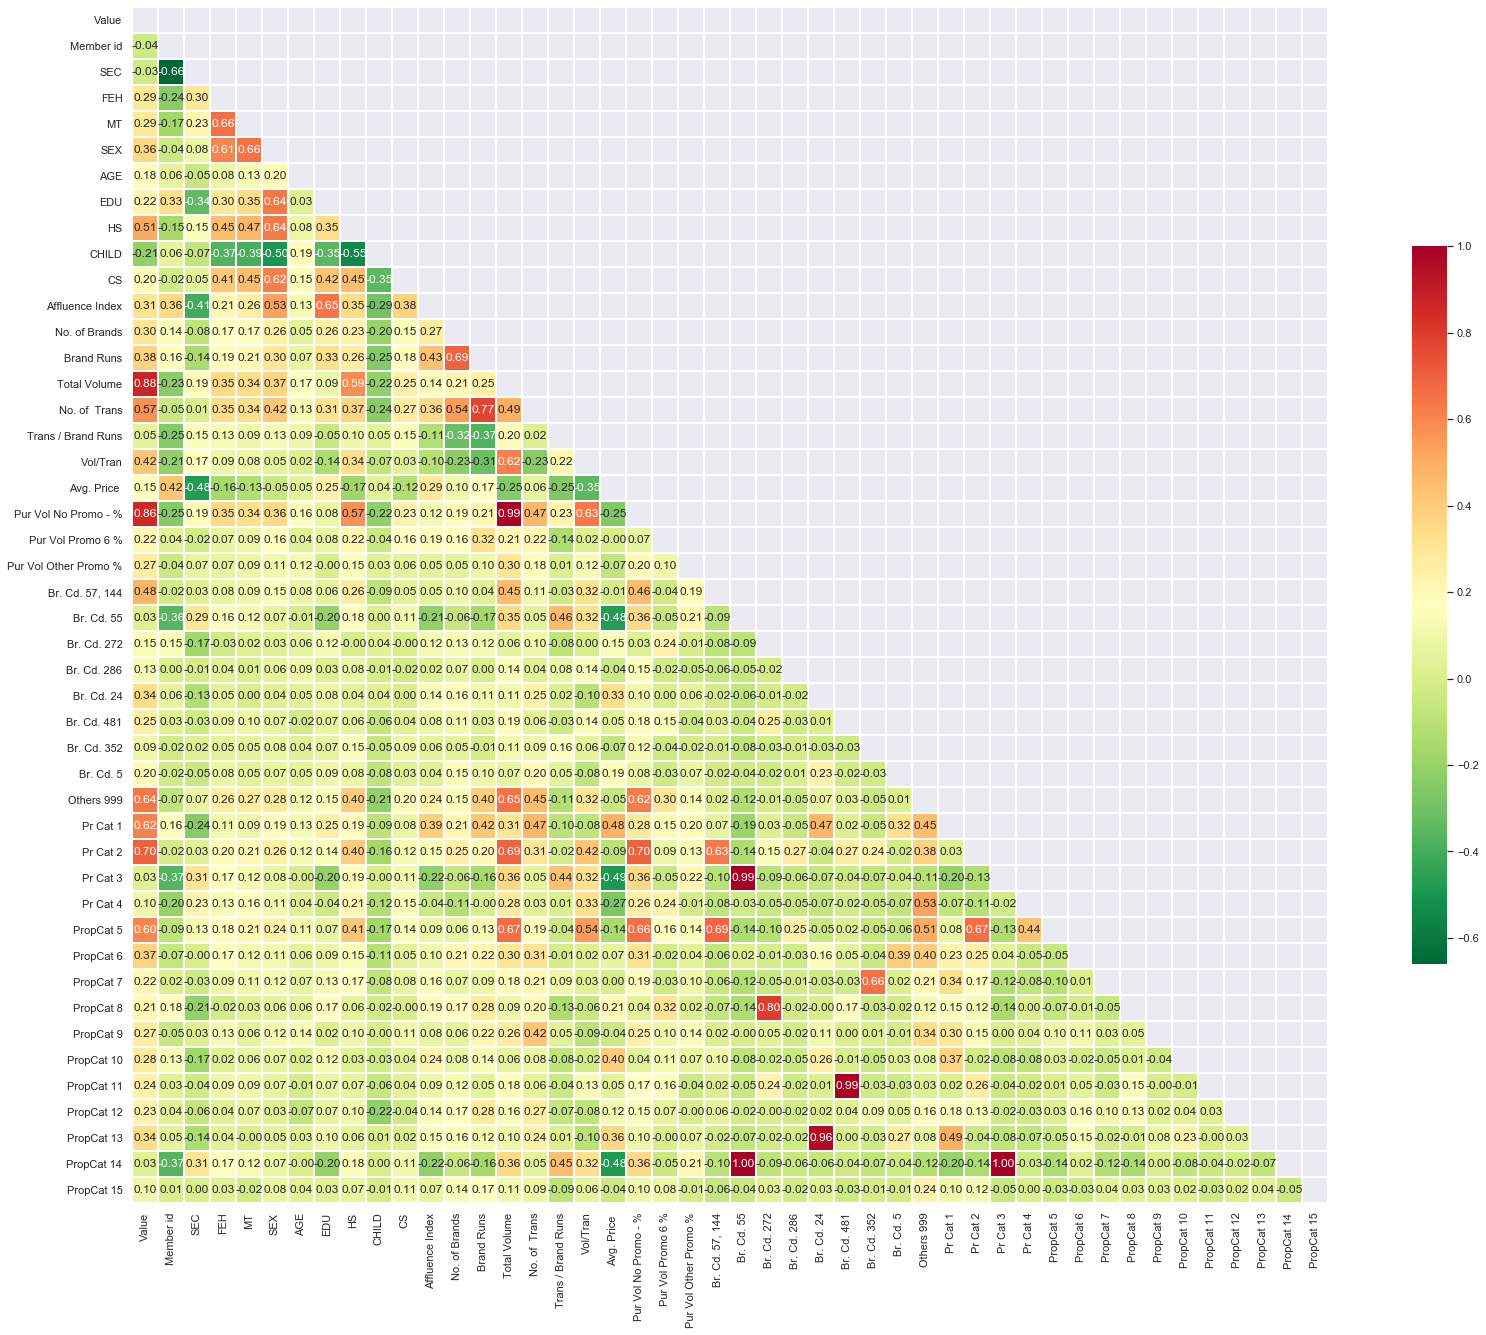

In [13]:
mask = np.triu(np.ones_like(bathsoap_df_copy.corr(), dtype=np.bool))

plt.figure(figsize=(30,22))
sns.heatmap(bathsoap_df_copy.corr(), mask=mask, annot=True, fmt='.2f', square=True, linewidths=.5,
            cmap="RdYlGn_r", cbar_kws={"shrink":.6})

# 변수별 상관관계 heatmap

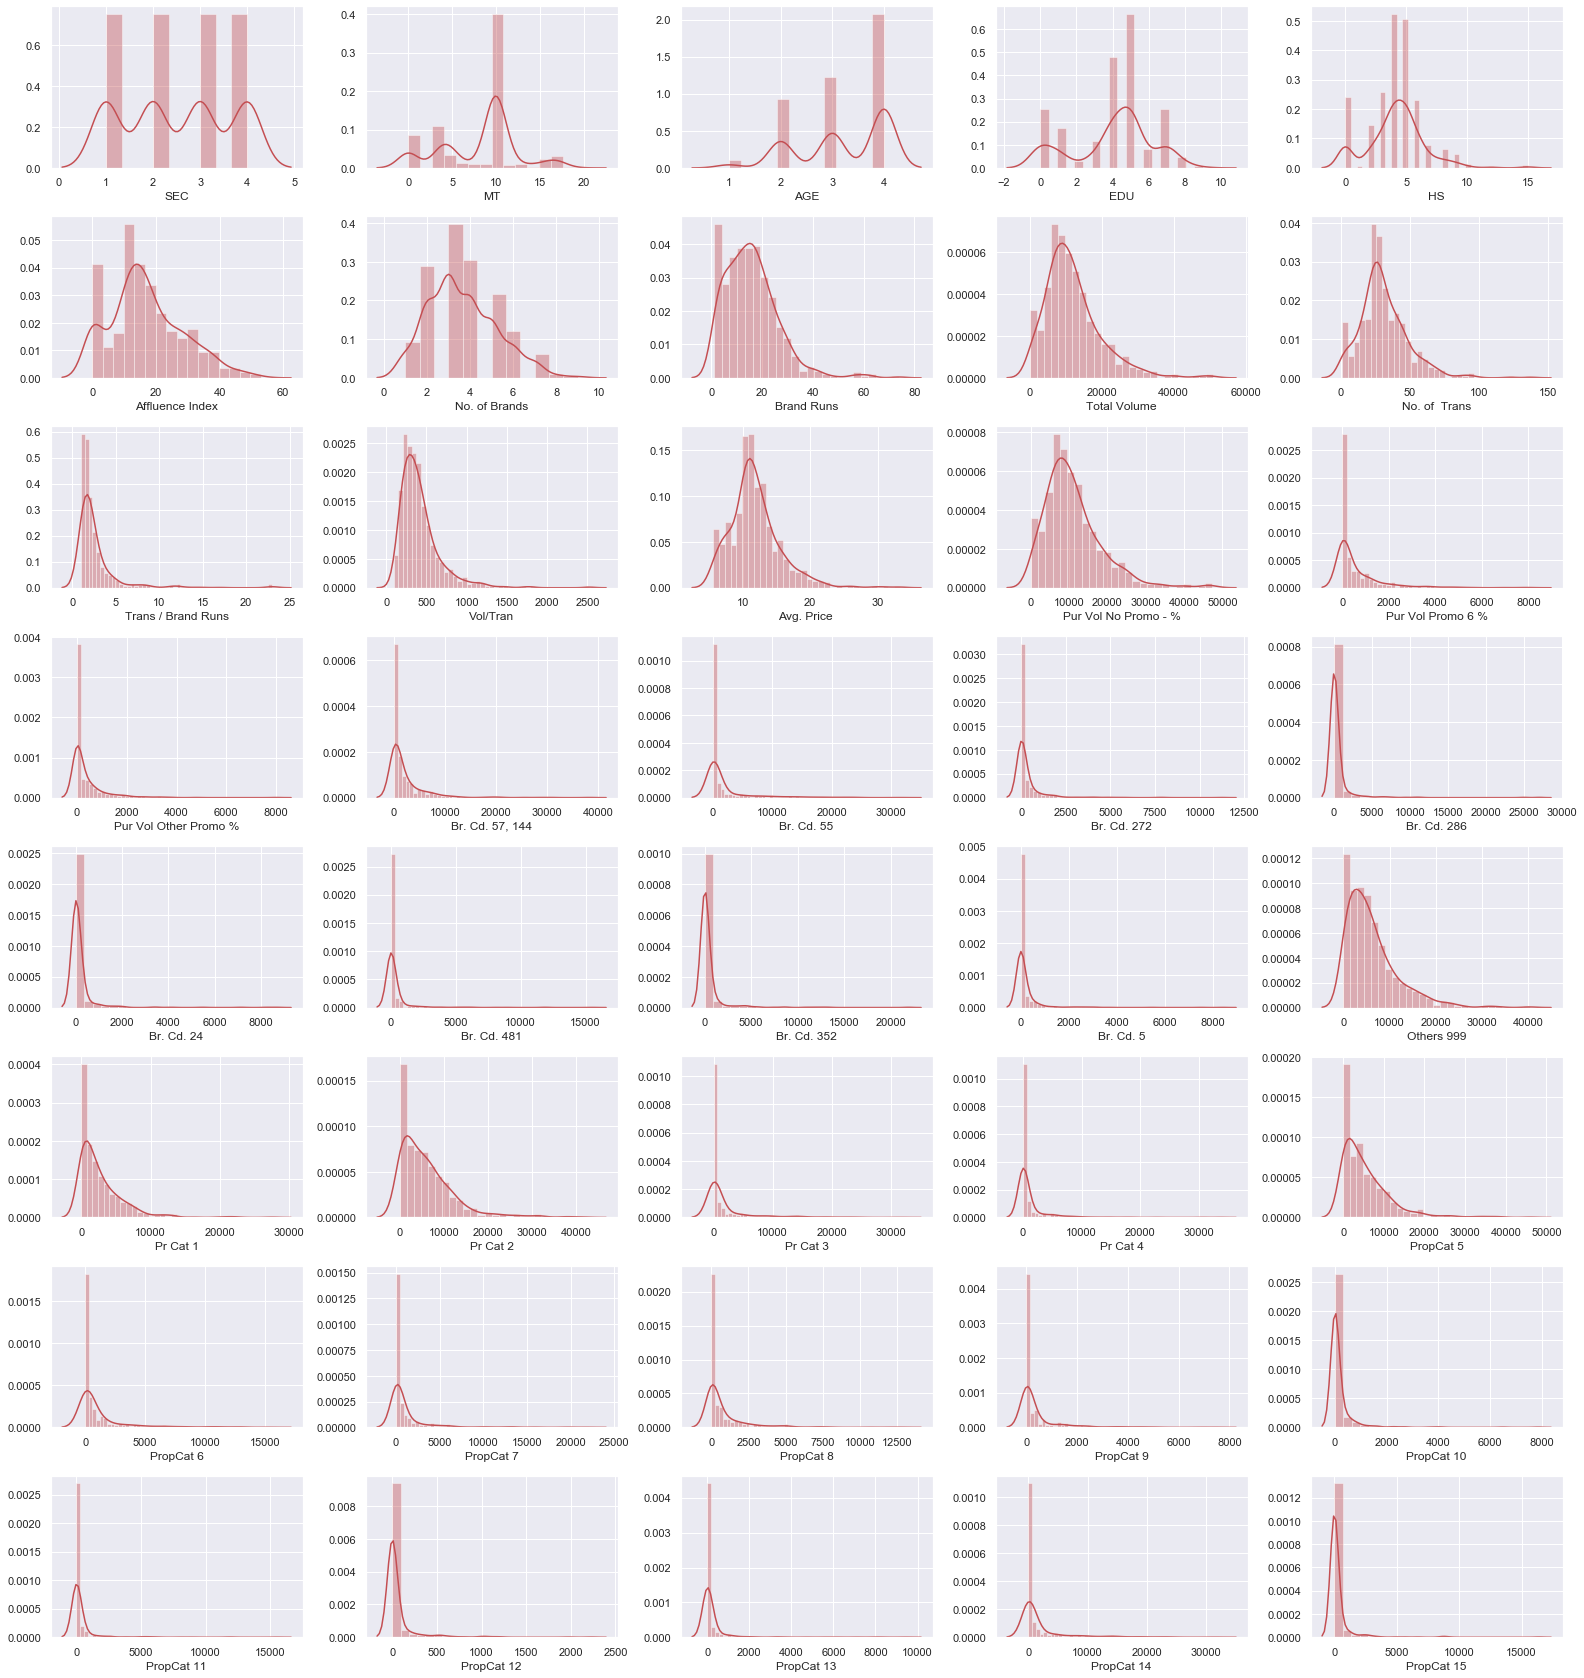

In [14]:
fig ,ax = plt.subplots(ncols=5, nrows=8, figsize=(30,30)) 

for index,feature in enumerate(bathsoap_feature_list):
    row = int(index / 5)
    col = index % 5    # 나머지 구하는 연산
    
    sns.distplot(bathsoap_df_copy[feature], ax=ax[row][col], color='r')
     # lmplot 함수에서 점들이 겹치게 출력되서 scatterplot으로 따로 산점도만 출력

plt.subplots_adjust(left=0.8, right=1.5, hspace=0.3, wspace=0.25)  # 서브플롯 위치조정
plt.show()

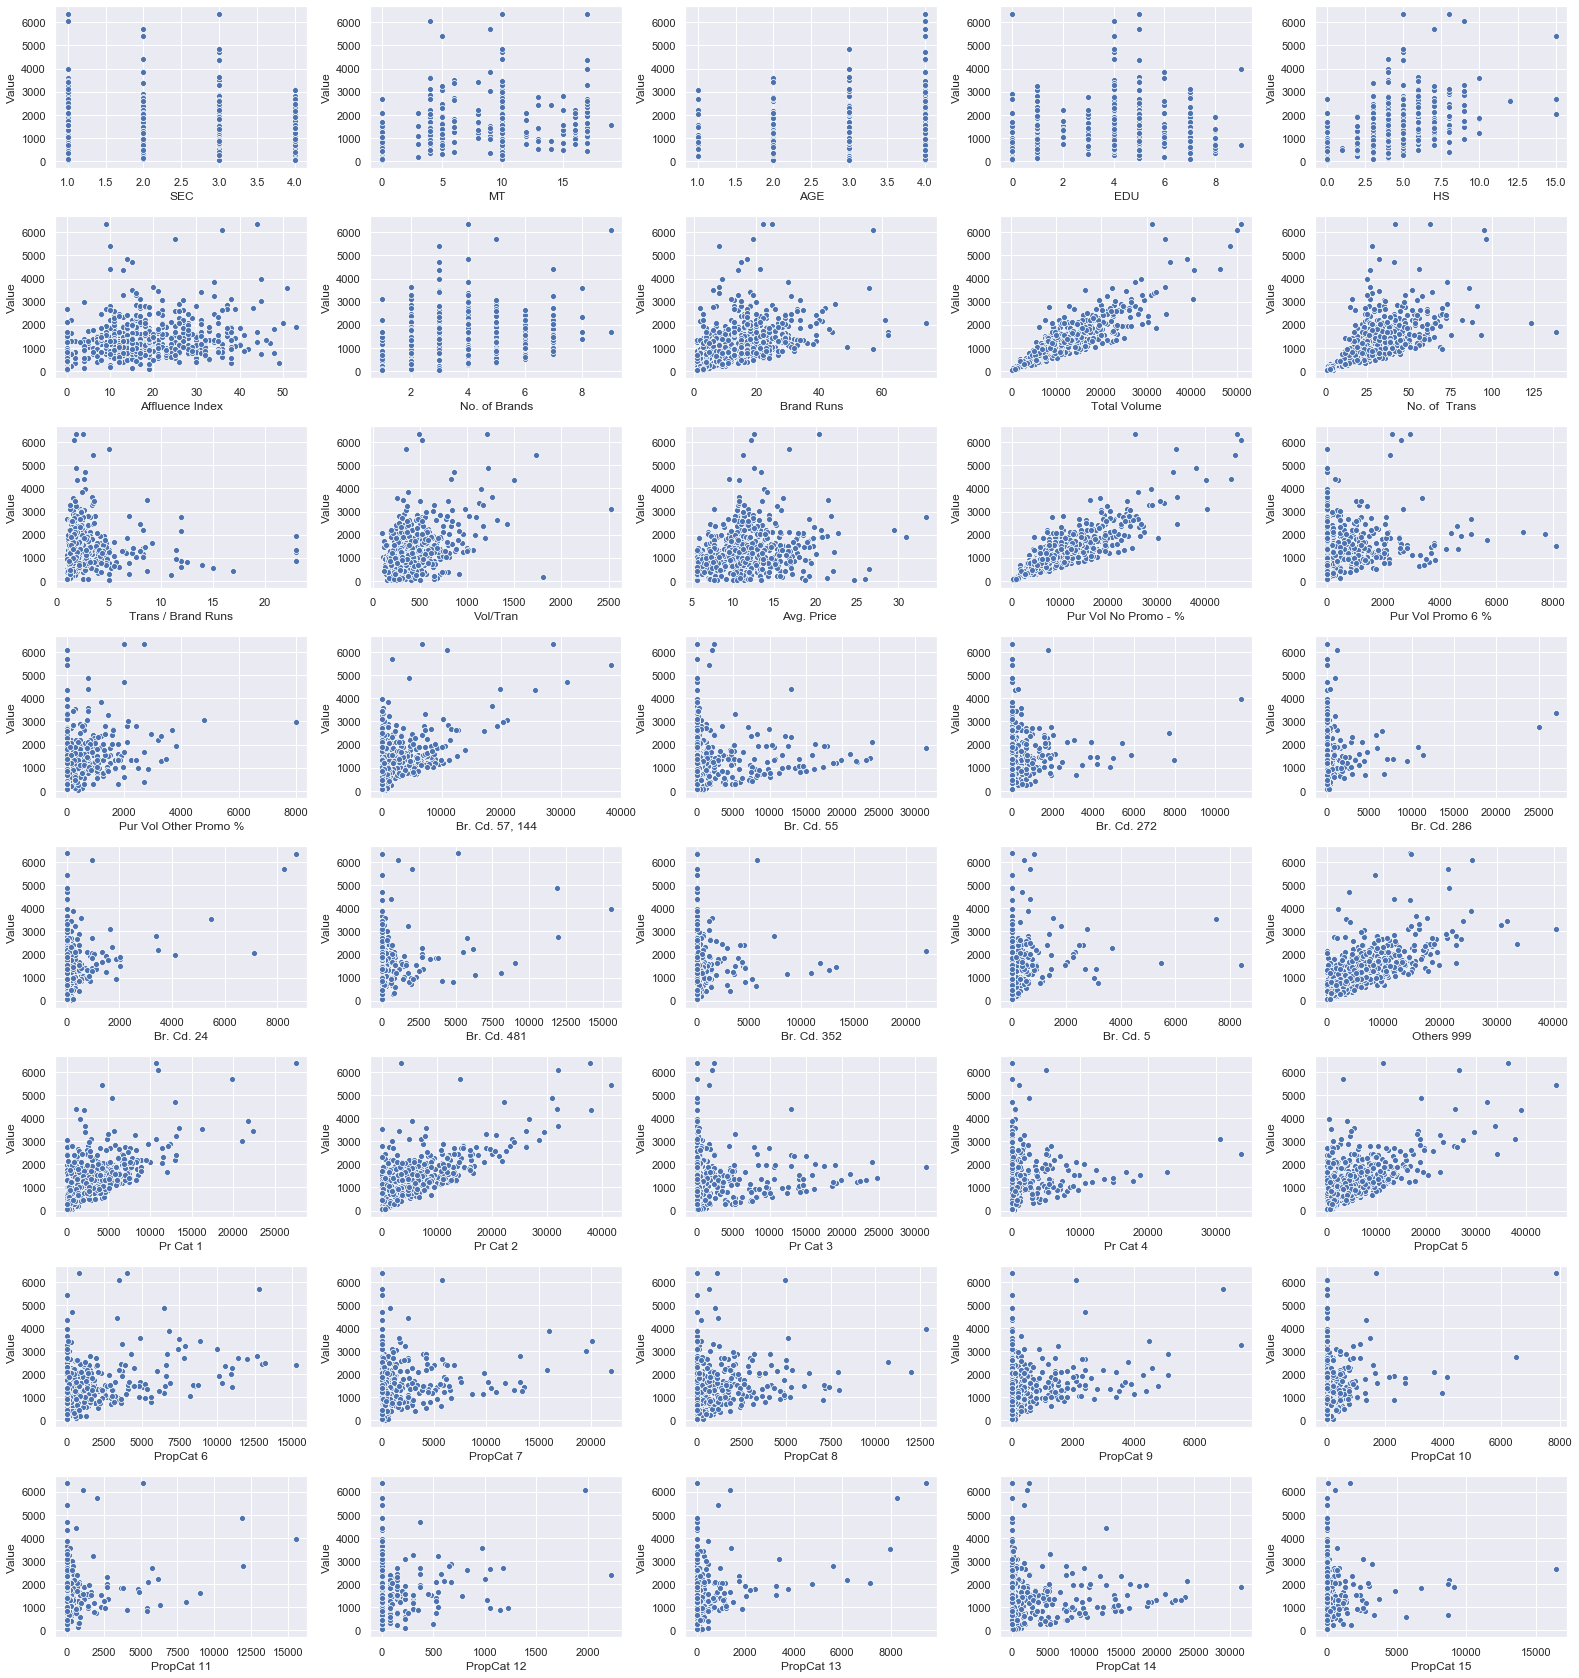

In [15]:
fig ,ax = plt.subplots(ncols=5, nrows=8, figsize=(30,30)) 

for index,feature in enumerate(bathsoap_feature_list):
    row = int(index / 5)
    col = index % 5    # 나머지 구하는 연산
    
    sns.scatterplot(x=bathsoap_df_copy[feature], y=bathsoap_df_copy['Value'], ax=ax[row][col])
     # lmplot 함수에서 점들이 겹치게 출력되서 scatterplot으로 따로 산점도만 출력

plt.subplots_adjust(left=0.8, right=1.5, hspace=0.3, wspace=0.25)  # 서브플롯 위치조정
plt.show()

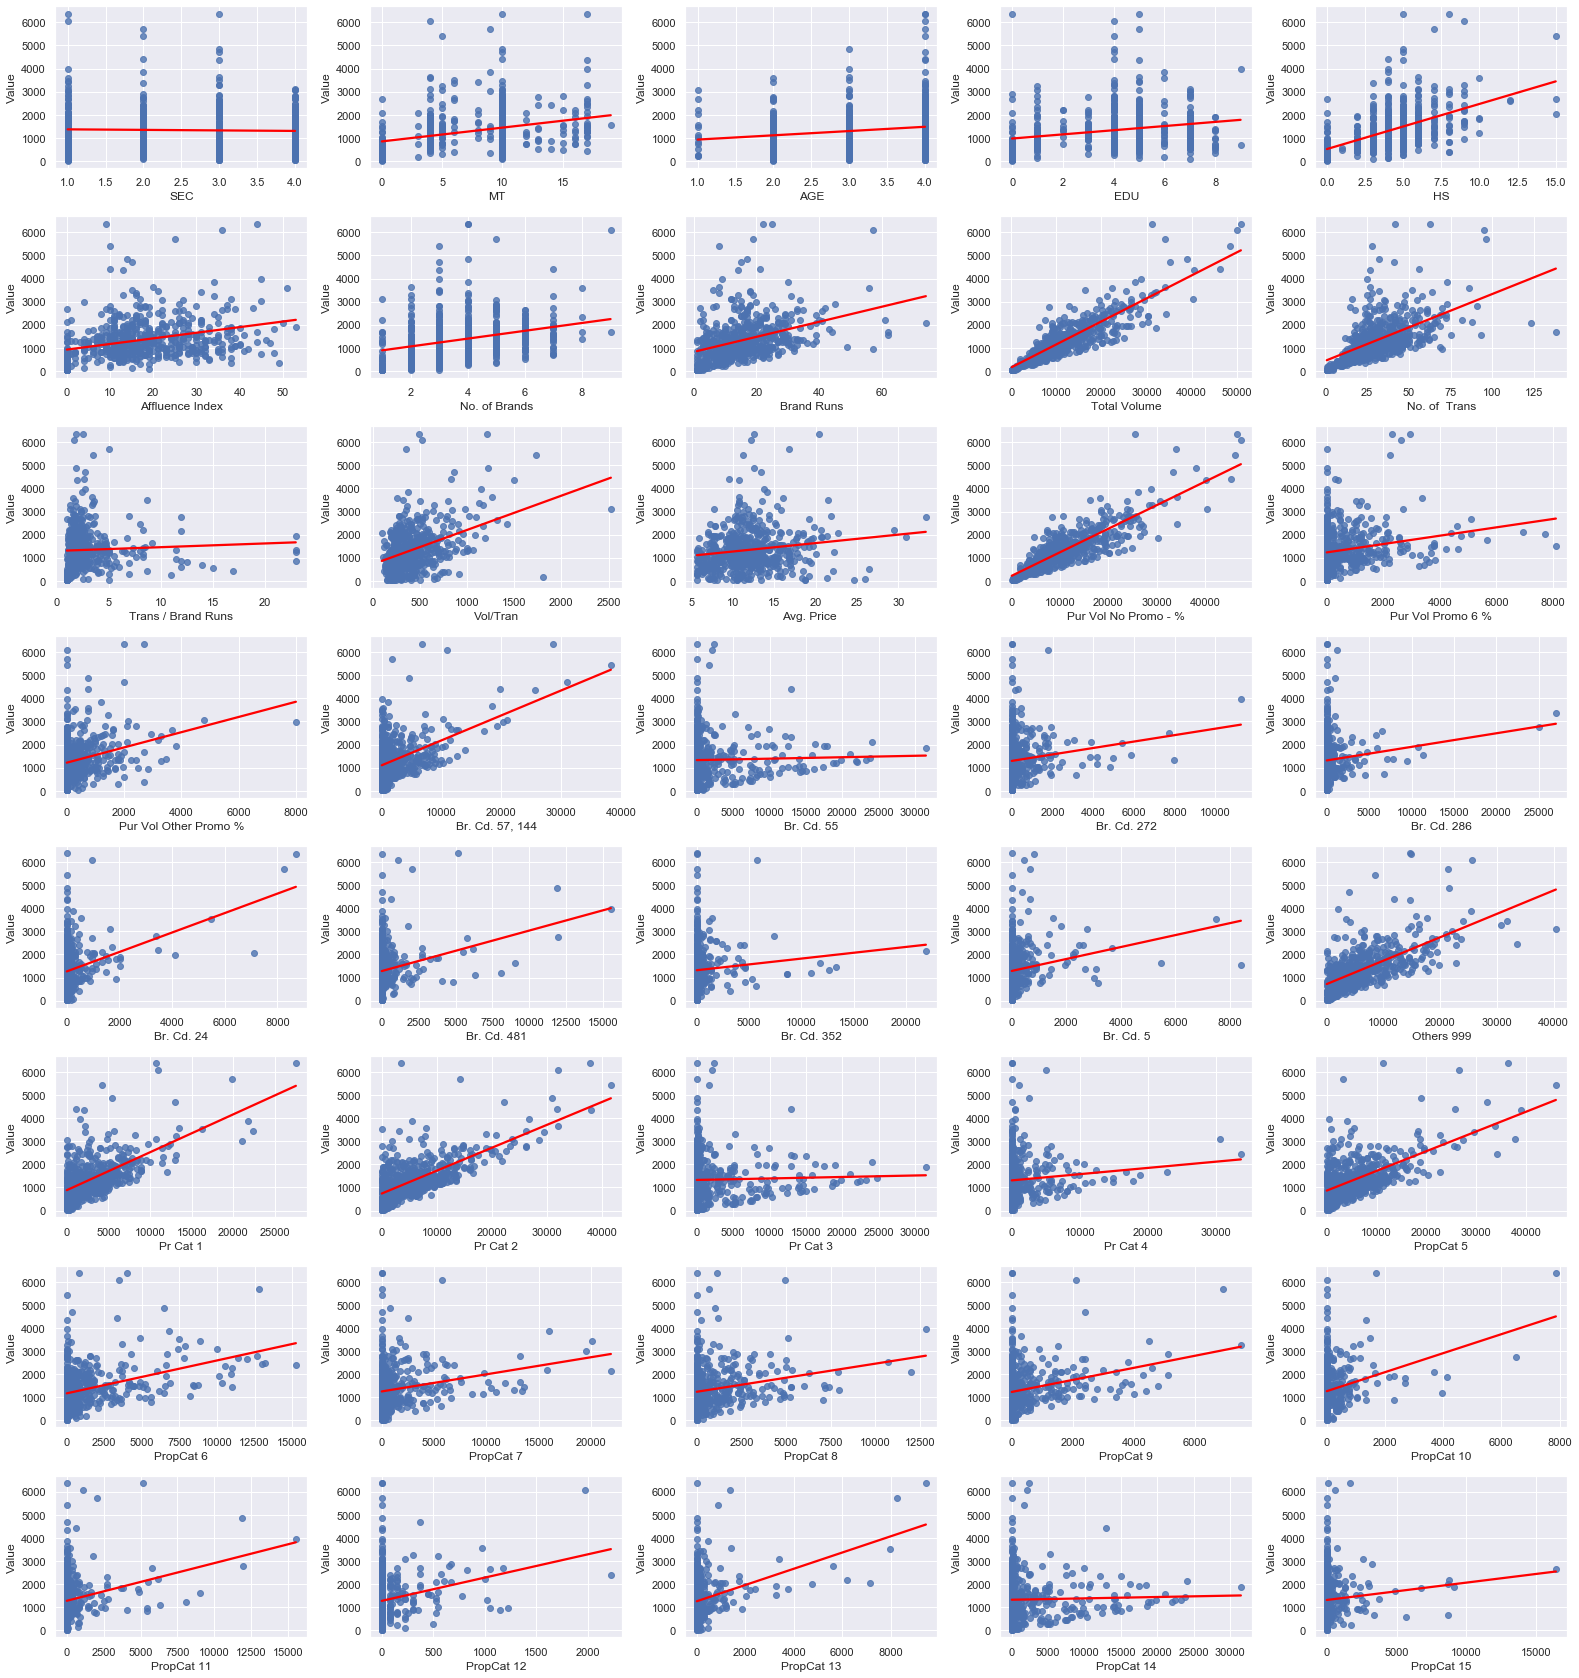

In [16]:
fig ,ax = plt.subplots(ncols=5, nrows=8, figsize=(30,30)) 
sns.set(style='darkgrid')
sns.set_context("notebook")  # 전체적인 스케일 조정(디폴트는 notebook)

for index,feature in enumerate(bathsoap_feature_list):
    row = int(index / 5)
    col = index % 5    # 나머지 구하는 연산
    
    sns.regplot(x=bathsoap_df_copy[feature], y=bathsoap_df_copy['Value'], ax=ax[row][col], line_kws = {'color' : 'red'}, ci=None)
     # lmplot은 ax 파라미터가 없는거 같음

plt.subplots_adjust(left=0.8, right=1.5, hspace=0.3, wspace=0.25)  # 서브플롯 위치조정
plt.show()

모든 변수가 Value와 양의 상관관계를 가짐. 

강한 상관관계
- Total Volume __0.88__
- Pur Vol No Promo - % __0.86__
- Pr Cat 2 __0.7__

뚜렷한 상관관계
- Others 999 __0.64__
- Pr Cat 1 __0.62__
- PropCat 5 __0.60__ 
- No. of Trans __0.57__ 
- HS __0.51__
- Br. Cd. 57, 144 __0.48__
- Vol/Tran __0.42__
- Brand Runs __0.38__
- PropCat 6 __0.37__
- SEX __0.36__
- Br. Cd. 24 __0.34__
- PropCat 13 __0.34__
- Affluence Index __0.31__
- No. of Brands __0.30__

▲ 위 히트맵 참고

* ## 데이터 전처리(방법 2번 bathsoap_df_copy으로 모델을 구현해봄)

###  Target 데이터 분포 파악 및 정규분포로 변환

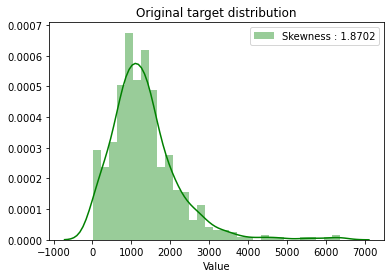

In [83]:
sns.distplot(bathsoap_df['Value'], label='Skewness : {}'.format(round(bathsoap_df['Value'].skew(),4)),
             color='g')
plt.title('Original target distribution')
plt.legend()
plt.show()

# 왜곡 정도가 1이 한참 넘어가기 때문에 완화해야함(로그변환 이용)
# target(종속변수) rkqtemfdl 정규분포에서 약간 벗어나있음.

In [84]:
bathsoap_df['Value']= np.log1p(bathsoap_df['Value'])

# 회귀모델 성과를 위해서 target 값들은 log1p() 함수로 로그변환

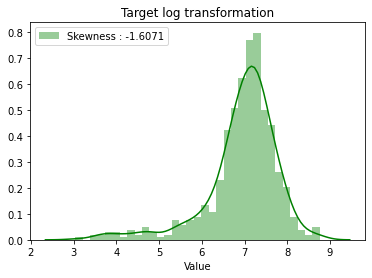

In [85]:
log_target = bathsoap_df['Value']
sns.distplot(log_target, label='Skewness : {}'.format(round(bathsoap_df['Value'].skew(),4)), color='g')
plt.title('Target log transformation')
plt.legend()
plt.show()

# 완전한 정규분포는 아니지만 치우침 정도가 -1.6 정도로 개선됨

### 이상치(Outlier) 처리
* 회귀계수가 높은 변수들을 미리 파악하고 해당 칼럼에 대해서 이상치 처리를 하는 방향으로

###  Feature 데이터 분포 파악 및 정규분포로 변환

* bathsoap 데이터의 경우 문자열 칼럼이 없으므로 Value(종속변수)를 제외한 나머지 칼럼들의 데이터분포의 치우침 정도를 확인

In [86]:
bathsoap_df_copy.drop(['Member id','CHILD','MT'], axis=1, inplace=True)
    
# 필요없는 변수 미리 삭제 

In [87]:
skew_colums = bathsoap_df_copy[bathsoap_df_copy.columns].apply(lambda x : skew(x), axis=0)

# 여기서 x 값이 무엇을 받는지 이해가 안됐는데 axis=0가 디폴트 값이여서 열 한줄을 한번에 처리한다는 의미였음(벡터연산)

skew_features = skew_colums[skew_colums>1.5]
bathsoap_df_copy[skew_features.index] = np.log1p(bathsoap_df_copy[skew_features.index])

* 일단 전체적으로 피쳐들의 왜곡이 심한편인데 1.2 이상인 피쳐들 모두 log1p(언더플로우 방지) 변환을 해줬음
* 현재 feature 데이터, target 데이터 모두 로그변환을 해서 어느 정도의 왜곡방지와 정규분포를 이루도록 만듦
* 왜곡이 1 이상이면 보통 높다고 했는데 

In [ ]:
skew_colums.sort_values(ascending=False)
# 로그 변환 전 칼럼 왜곡 정도

In [ ]:
bathsoap_df_copy[bathsoap_df_copy.columns].apply(lambda x : skew(x), axis=0).sort_values(ascending=False)
# 로그 변환 후 칼럼 왜곡 정도
# 로그 변환을 계속할 수는 업기에 이 정도로 변환을 해둠

### 원핫인코딩 & 데이터 파티션

In [88]:
bathsoap_df_copy_oh = pd.get_dummies(bathsoap_df_copy, columns=['FEH', 'CS', 'SEX']) 

feature_data =  bathsoap_df_copy_oh.drop('Value', axis=1, inplace=False) # 피쳐 데이터 세트(로그 변환된)
target_data = bathsoap_df['Value']  # 타겟 데이터 세트(로그 변환된)

X_train, X_test,y_train, y_test = train_test_split(feature_data, target_data, test_size=0.3, random_state=1)

# 학습용, 평가용 데이터(30%)로 분리

* 처음에 분류했던 숫자형 카테로리 칼럼(숫자 크기가 의미가 없는) FEH (식습관),CS(TV 유무),SEX(전업 주부 성별)인 더미화 처리
* Age도 숫자형 카테고리 칼럼이지만 숫자의 크기가 의미가 있다고 생각해서 더미화 따로 하지 않음.

### 학습 & 예측 & 평가

In [89]:
lr_reg =LinearRegression(fit_intercept=True)   
knn_reg = KNeighborsRegressor()
# 선형회귀, KNlr_reg =LinearRegression(fit_intercept=True)   
knn_reg = KNeighborsRegressor()
# 선형회귀, KNN회귀 알고리즘 클래스 객체로 만들기

parameters = {'n_neighbors' : range(2,9)}
grid_knn_reg = GridSearchCV(knn_reg, param_grid=parameters, cv=5, refit=True)

lr_reg.fit(X_train, y_train)
grid_knn_reg.fit(X_train, y_train)
# 학습데이터로 알고리즘 학습


best_knn_reg = grid_knn_reg.best_estimator_

pred_lr_reg = lr_reg.predict(X_test)
pred_knn_reg = best_knn_reg.predict(X_test)

# 각각 알고리즘으로 테스트 데이터 세트에 대한 예측값 반환

y_test_exmp = np.expm1(y_test)    # 위에서 y_test 데이터가 로그값으로 받았으니 예측 평가를 위해 expm1() 함수로 원래 값으로 변환
pred_lr_reg_exmp = np.expm1(pred_lr_reg)   # 예측값 역시 로그 변환값으로 도출되기 때문에 원래 값으로 변환
pred_knn_reg_exmp = np.expm1(pred_knn_reg) # 회귀 알고리즘 클래스 객체로 만들기

In [90]:
models = [lr_reg, knn_reg]

def cross_val_eval(feature, target, models):
    
    for model in models:
        neg_mse_score = cross_val_score(model, feature, target, scoring='neg_mean_squared_error', cv=5)
        neg_mae_score = cross_val_score(model, feature, target, scoring='neg_mean_absolute_error', cv=5)
    
        rmse_score = np.round(np.sqrt(-1*neg_mse_score), 3)
        avg_rmse = np.round(np.mean(rmse_score), 3)
        mae_score = np.round(np.mean(-1*neg_mae_score), 3)
   
        print(model.__class__.__name__)
        print("5개 폴드 교차검증 RMSE 리스트: {0}".format(rmse_score))
        print("5개 폴드 교차검증 평균 RMSE: {0:.3f}".format(avg_rmse))
    
        print("5개 폴드 교차검증 MAE 리스트: {0} ".format(-1*neg_mae_score))
        print("5개 폴드 교차검증 평균 MAE: {0:.3f}".format(mae_score),end='\n')

# cross_val_score로 test 데이터로 평가전에 학습데이터로 학습/예측/평가 후 일반성 검증

In [91]:
cross_val_eval(feature_data, target_data, models)

LinearRegression
5개 폴드 교차검증 RMSE 리스트: [0.147 0.41  0.156 0.191 0.169]
5개 폴드 교차검증 평균 RMSE: 0.215
5개 폴드 교차검증 MAE 리스트: [0.11462562 0.10744576 0.09885558 0.1229224  0.1161127 ] 
5개 폴드 교차검증 평균 MAE: 0.112
KNeighborsRegressor
5개 폴드 교차검증 RMSE 리스트: [0.411 0.337 0.285 0.34  0.293]
5개 폴드 교차검증 평균 RMSE: 0.333
5개 폴드 교차검증 MAE 리스트: [0.33199623 0.25904849 0.22378827 0.26497713 0.23431505] 
5개 폴드 교차검증 평균 MAE: 0.263


* 사이킷런에서 mean_absolute_percentage_error(MAPE) 지표는 따로 없는 것 같다.

In [92]:
def evaluate_pred(y, y_pred, model):     
   
    mse = mean_squared_error(y, y_pred)   # 평균제곱오차
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)    # 평균절대오차
    mape = np.mean(np.abs((y-y_pred) / y)) * 100   # MAPE(평균절대비율오차)는 퍼센트(%) 비율이고 MAE랑 다르게 Y(실제값)으로 나눠줌
    
    print(model.__class__.__name__)
    print('MSE: {0: 0.3f}, RMSE: {1: 0.3f}, MAE: {2: 0.3f}, MAPE: {3: 0.3f}'.format(mse, rmse, mae, mape))
    

# 예측 성능 평가 지표 차례대로 MSE,  RMSE,  MAE, MAPE 
# MAPE  = 예측결과가 평균적으로 얼마나 실제치에서 벗어나 있는지를 백분율의 점수

In [93]:
 evaluate_pred(y_test_exmp, pred_lr_reg_exmp, lr_reg)

LinearRegression
MSE:  39676.704, RMSE:  199.190, MAE:  128.510, MAPE:  12.781


In [94]:
 evaluate_pred(y_test_exmp, pred_knn_reg_exmp, knn_reg)

KNeighborsRegressor
MSE:  166392.034, RMSE:  407.912, MAE:  295.798, MAPE:  26.049


### 각각 feature 별 회귀 계수 추출

In [95]:
pd.Series(np.round(lr_reg.coef_, 2), index=feature_data.columns).sort_values(ascending=False)

Vol/Tran                 0.46
Trans / Brand Runs       0.45
Pur Vol No Promo - %     0.36
SEX_2                    0.14
Others 999               0.08
FEH_0                    0.08
SEX_1                    0.07
Avg. Price               0.05
Br. Cd. 272              0.03
PropCat 5                0.03
Br. Cd. 481              0.03
Br. Cd. 5                0.03
Pr Cat 2                 0.03
Br. Cd. 57, 144          0.02
Br. Cd. 55               0.02
Br. Cd. 286              0.02
Br. Cd. 24               0.02
Br. Cd. 352              0.02
Pr Cat 1                 0.02
CS_1                     0.02
PropCat 6                0.01
PropCat 13               0.01
Brand Runs               0.01
CS_2                     0.01
Pur Vol Promo 6 %        0.01
PropCat 7                0.01
PropCat 14               0.01
Pur Vol Other Promo %    0.01
PropCat 10               0.01
PropCat 8                0.01
PropCat 12               0.00
No. of  Trans            0.00
PropCat 15               0.00
AGE       

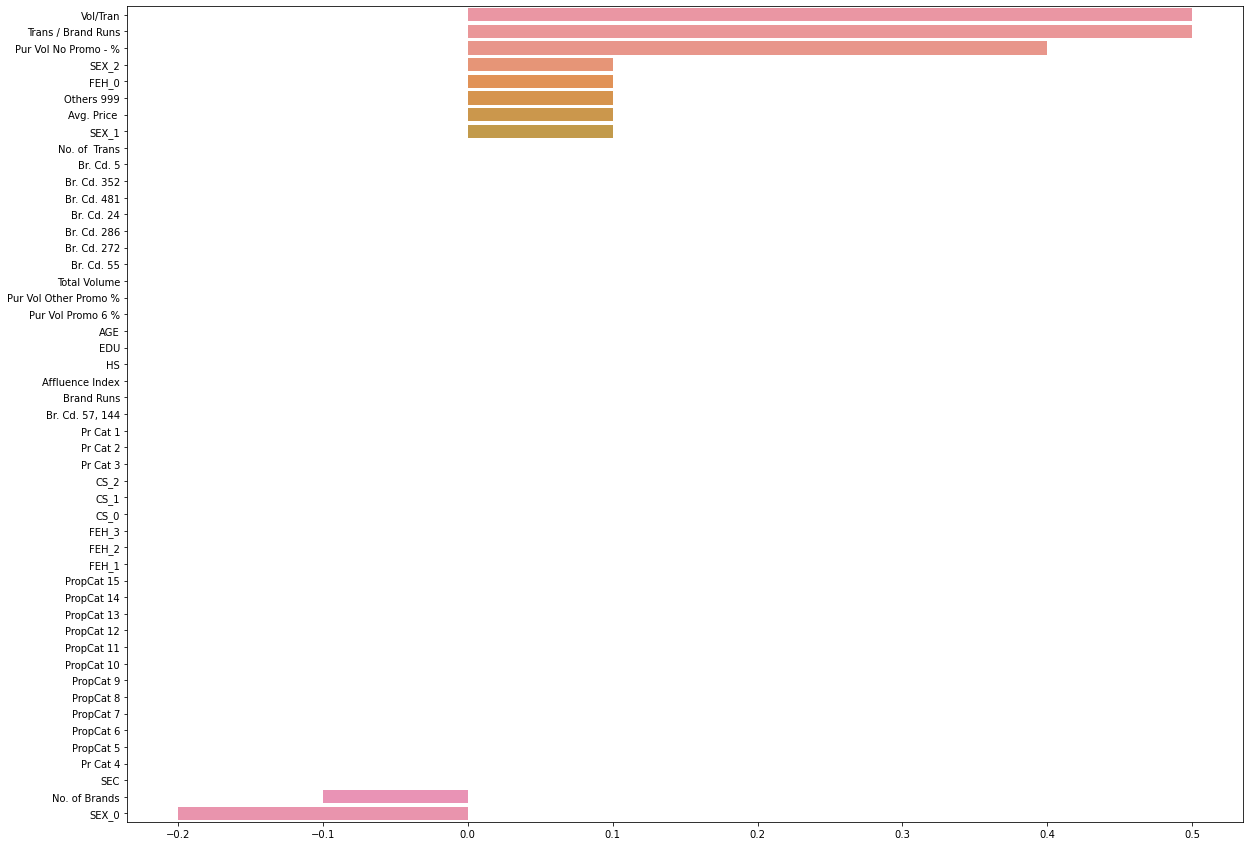

In [96]:
coef = pd.Series(data=np.round(lr_reg.coef_, 1), index=feature_data.columns)
coef_sort = coef.sort_values(ascending=False)

plt.figure(figsize=(20,15))
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 이상치(Outlier) 처리
* 회귀계수 파악 후 상위 4개 피쳐들에 한하여 이상치 제거(전체 데이터 600개인걸 고려해서)
* 회귀계수가 높은 피쳐들의 원본에서 범위 값을 지정한 후 로그(log1p)를 취하는 방식으로

#### 1. Trans / Brand Runs(연속제품 구매당 평균 거래 건수), 회귀계수 0.46

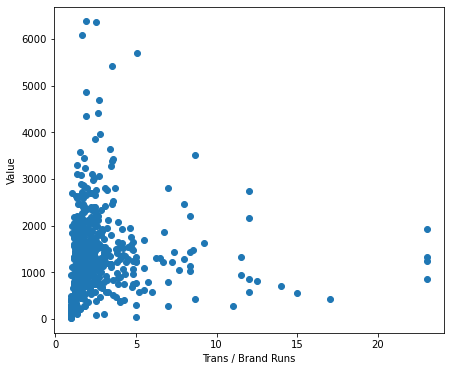

In [97]:
plt.figure(figsize=(7,6))
plt.ylabel('Value')
plt.xlabel('Trans / Brand Runs')
plt.scatter(x=bathsoap_df_copy2['Trans / Brand Runs'], y=bathsoap_df_copy2['Value'])

In [98]:
cond1 = feature_data['Trans / Brand Runs'] > np.log1p(15)
cond2 = target_data > np.log1p(4600)
outlier_index = feature_data[cond1 | cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 feature_data shape :', feature_data.shape)

feature_data.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 feature_data shape :', feature_data.shape, end='\n')

print('이상치 삭제 전 target_data shape :', target_data.shape)

target_data.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 target_data shape :', target_data.shape)

이상치 레코드 index : [ 33  38 123 162 178 204 221 238 270 280 494 574]
이상치 삭제 전 feature_data shape : (600, 49)
이상치 삭제 후 feature_data shape : (588, 49)
이상치 삭제 전 target_data shape : (600,)
이상치 삭제 후 target_data shape : (588,)


#### 2.  Vol/Tran (연속제품 구매당 평균 거래 건수), 회귀계수  0.43

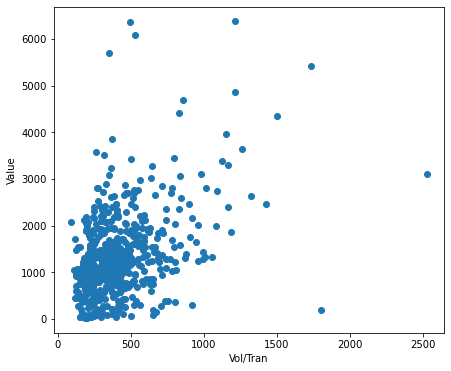

In [99]:
plt.figure(figsize=(7,6))
plt.ylabel('Value')
plt.xlabel('Vol/Tran')
plt.scatter(x=bathsoap_df_copy2['Vol/Tran'], y=bathsoap_df_copy2['Value'])

In [100]:
cond1 = feature_data['Vol/Tran'] > np.log1p(1600)
cond2 = target_data > np.log1p(5500)
outlier_index = feature_data[cond1 | cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 feature_data shape :', feature_data.shape)

feature_data.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 feature_data shape :', feature_data.shape, end='\n')

print('이상치 삭제 전 target_data shape :', target_data.shape)
target_data.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 target_data shape :', target_data.shape)

이상치 레코드 index : [250 523]
이상치 삭제 전 feature_data shape : (588, 49)
이상치 삭제 후 feature_data shape : (586, 49)
이상치 삭제 전 target_data shape : (588,)
이상치 삭제 후 target_data shape : (586,)


#### 3. Pur Vol No Promo - % (판촉 외의 구매량 비율), 회귀계수  0.37

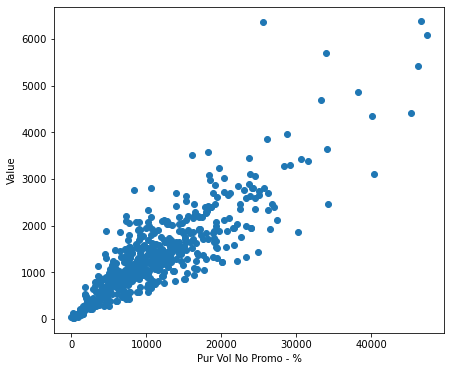

In [101]:
plt.figure(figsize=(7,6))
plt.ylabel('Value')
plt.xlabel('Pur Vol No Promo - %')
plt.scatter(x=bathsoap_df_copy2['Pur Vol No Promo - %'], y=bathsoap_df_copy2['Value'])

In [102]:
cond1 = (np.log1p(23000) < feature_data['Pur Vol No Promo - %']) & (feature_data['Pur Vol No Promo - %'] < np.log1p(30000))
cond2 = target_data > np.log1p(6000)
outlier_index = feature_data[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 feature_data shape :', feature_data.shape)

feature_data.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 feature_data shape :', feature_data.shape)

print('이상치 삭제 전 target_data shape :', target_data.shape)
target_data.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 target_data shape :', target_data.shape)

이상치 레코드 index : []
이상치 삭제 전 feature_data shape : (586, 49)
이상치 삭제 후 feature_data shape : (586, 49)
이상치 삭제 전 target_data shape : (586,)
이상치 삭제 후 target_data shape : (586,)


#### 4. SEX_0(전업 주부의 성별 = 알수없음, 더미화 변수), 회귀계수 -0.22

In [103]:
bathsoap_df_copy2['SEX'].value_counts()
# 1 = 남성 2 = 여성

2    511
0     68
1     21
Name: SEX, dtype: int64

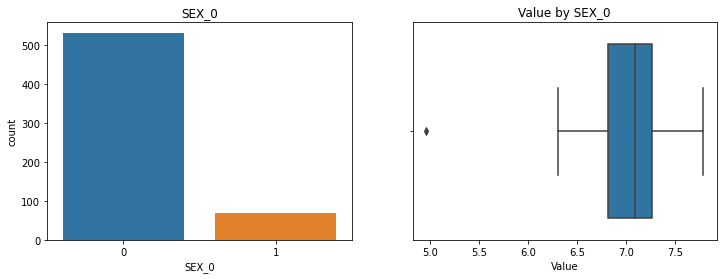

In [104]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

sns.countplot(bathsoap_df_copy_oh['SEX_0'], ax=ax[0])
ax[0].set_title('SEX_0')

sns.boxplot(bathsoap_df_copy_oh[bathsoap_df_copy2['SEX'] == 1]['Value'], ax=ax[1])
ax[1].set_title('Value by SEX_0')

feature_data.drop(307, axis=0, inplace=True)    # 성별이 0인 사람들 중 value값이 조금 벗어난 값 하나만 삭제
target_data.drop(307, axis=0, inplace=True) 

In [105]:
target_data.shape

(585,)

In [106]:
feature_data.shape

(585, 49)

__이상치만 처리한 후의 데이터로 다시 학습-예측 해보기__

In [107]:
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.3, random_state=1)

# 학습용, 평가용 데이터(30%)로 분리

In [110]:
lr_reg =LinearRegression(fit_intercept=True)   
knn_reg = KNeighborsRegressor()
# 선형회귀, KNlr_reg =LinearRegression(fit_intercept=True)   
knn_reg = KNeighborsRegressor()
# 선형회귀, KNN회귀 알고리즘 클래스 객체로 만들기

parameters = {'n_neighbors' : range(2,9)}
grid_knn_reg = GridSearchCV(knn_reg, param_grid=parameters, cv=5, refit=True)

lr_reg.fit(X_train, y_train)
grid_knn_reg.fit(X_train, y_train)
# 학습데이터로 알고리즘 학습


best_knn_reg = grid_knn_reg.best_estimator_

pred_lr_reg = lr_reg.predict(X_test)
pred_knn_reg = best_knn_reg.predict(X_test)

# 각각 알고리즘으로 테스트 데이터 세트에 대한 예측값 반환

y_test_exmp = np.expm1(y_test)    # 위에서 y_test 데이터가 로그값으로 받았으니 예측 평가를 위해 expm1() 함수로 원래 값으로 변환
pred_lr_reg_exmp = np.expm1(pred_lr_reg)   # 예측값 역시 로그 변환값으로 도출되기 때문에 원래 값으로 변환
pred_knn_reg_exmp = np.expm1(pred_knn_reg) # 회귀 알고리즘 클래스 객체로 만들기

In [111]:
 evaluate_pred(y_test_exmp, pred_lr_reg_exmp, lr_reg)

LinearRegression
MSE:  53640.953, RMSE:  231.605, MAE:  131.802, MAPE:  11.288


기존 전처리 전 MSE:  39676.704, RMSE:  199.190, MAE:  128.510, MAPE:  12.781

In [112]:
 evaluate_pred(y_test_exmp, pred_knn_reg_exmp , knn_reg)

KNeighborsRegressor
MSE:  131677.094, RMSE:  362.873, MAE:  266.001, MAPE:  23.111


기존 전처리 전 MSE:  166392.034, RMSE:  407.912, MAE:  295.798, MAPE:  26.049

### Feature 재설정

In [113]:
bathsoap_new = pd.concat([target_data,feature_data], axis=1, sort=False)

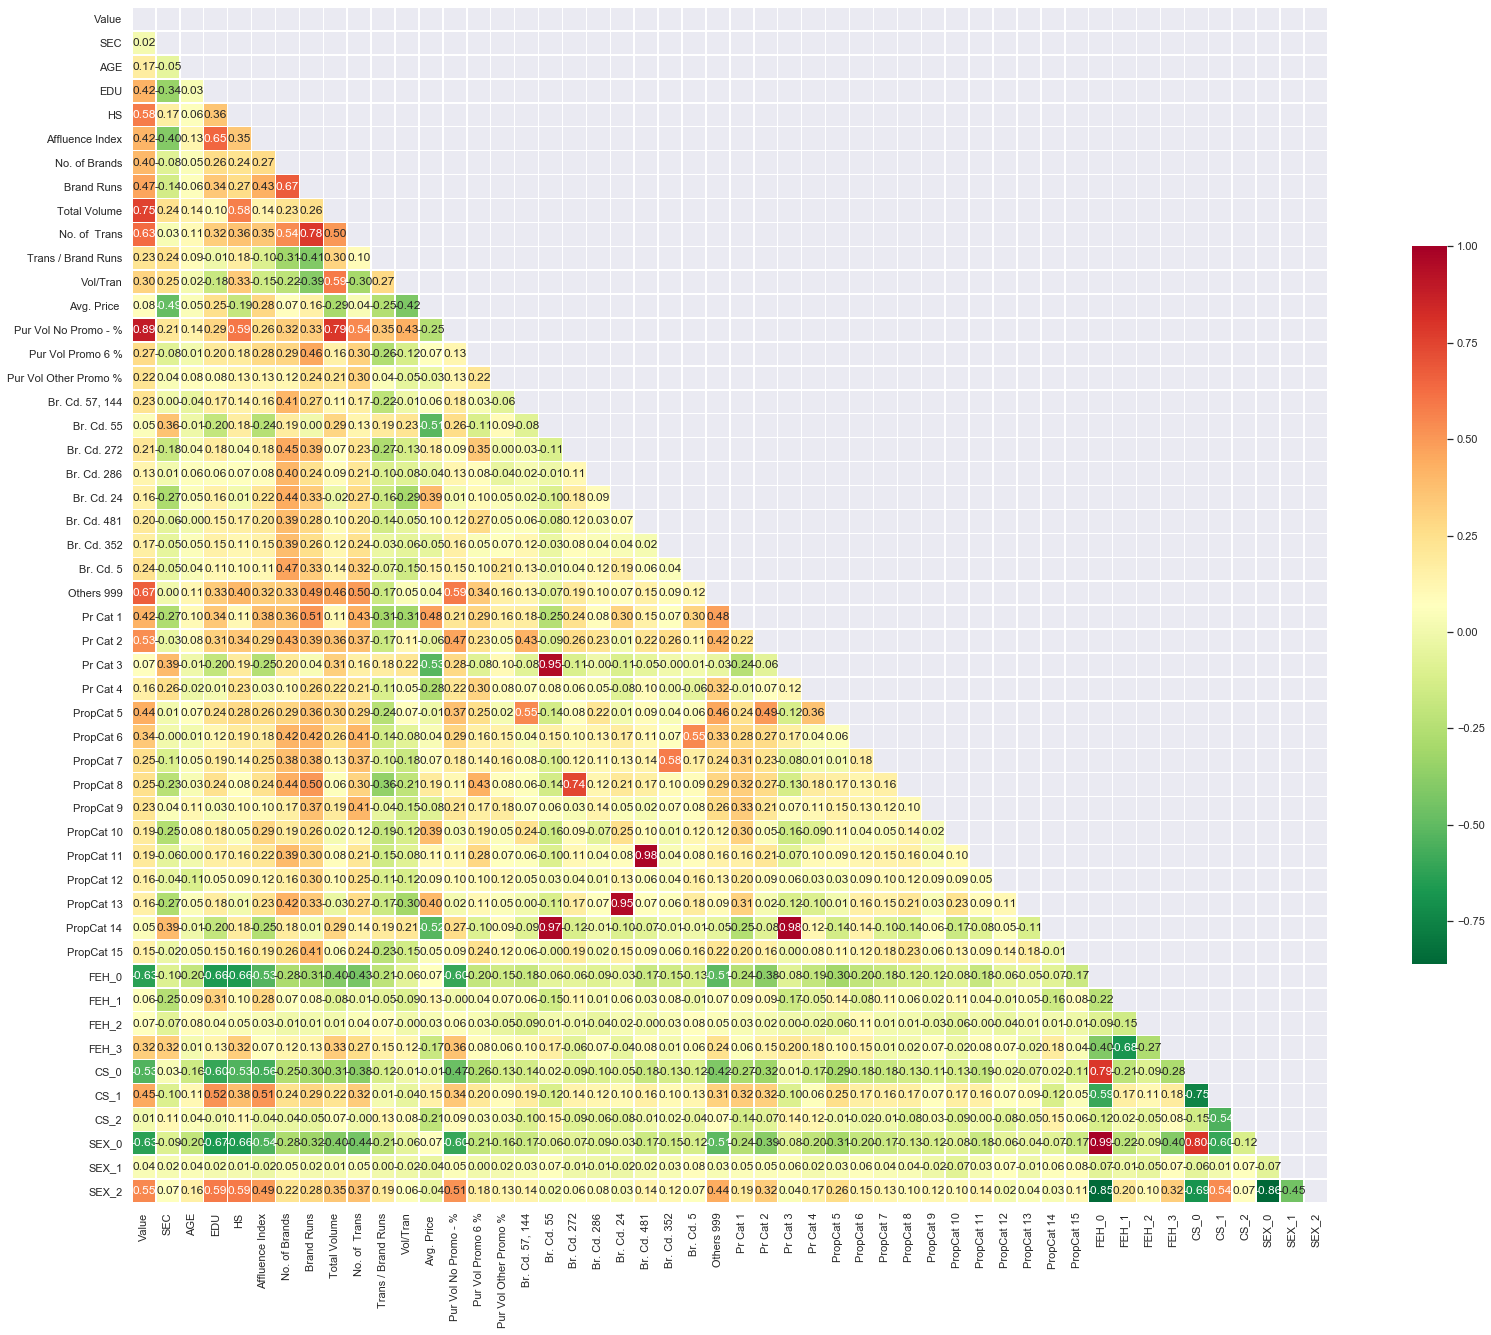

In [47]:
mask = np.triu(np.ones_like(bathsoap_new.corr(), dtype=np.bool))

plt.figure(figsize=(30,22))
sns.heatmap(bathsoap_new.corr(), mask=mask, annot=True, fmt='.2f', square=True, linewidths=.5,
            cmap="RdYlGn_r", cbar_kws={"shrink":.6})

# 변수별 상관관계 heatmap

강한 양적 상관관계에 있는 변수쌍 : <br>
- SEX_0 & FEH_0 __(0.99)__
- PropCat 14 & Pr Cat 3 __(0.98)__
- Br. Cd. 481 & PropCat 11 __(0.98)__
- Br. Cd. 55 & PropCat 14 __(0.97)__
- Br. Cd. 55 & Pr Cat 3 __(0.95)__
- Br. Cd. 24 & PropCat 13 __(0.95)__
- SEX_0 & SEX_2 __(-0.86)__
- FEH_0 & SEX_2 __(-0.85)__
- SEX_0 & CS_0 __(0.80)__ 
- FEH_0 & CS_0 __(0.79)__
- Pur Vol No Promo - % & Total Volume __(0.79)__
- No. of Trans & Brand Runs __(0.78)__
- CS_0 & CS_1 __(-0.75)__
- PropCat 8 & Br. Cd. 272 __(0.74)__
- CS_0 & SEX_2 __(-0.69)__
- FEH_1 & FEH_3 __(-0.68)__
- SEX_0 & EDU __(-0.67)__

앞서 살펴봤던, 영향력 높은 (회귀계수 높은) 변수들

Trans / Brand Runs       __0.46__

Vol/Tran                 __0.43__

Pur Vol No Promo - %     __0.37__

SEX_0                   __-0.22__

No. of Brands           __-0.14__

SEX_2                    __0.13__

FEH_0                    __0.09__

Others 999               __0.08__

SEX_1                    __0.08__


__삭제할 변수 선정하기__

- 회귀계수가 0이었던 변수들

PropCat 12            

No. of  Trans         

PropCat 15           

AGE                    

EDU                     

Affluence Index        

PropCat 9                

Pr Cat 4                

Total Volume             

In [114]:
# 회귀계수가 0이었던 변수들 drop

feature_data.drop(['PropCat 12','No. of  Trans','PropCat 15','AGE','EDU','Affluence Index','PropCat 9','Pr Cat 4','Total Volume'],
                  axis=1, inplace=True)

__변수 삭제 후 다시 학습-예측__(이상치 제거 & 회귀계수 0인 변수들 제거)

In [115]:
X_train, X_test,y_train, y_test = train_test_split(feature_data, target_data, test_size=0.3, random_state=1)

# 학습용, 평가용 데이터(30%)로 분리

In [116]:
lr_reg =LinearRegression(fit_intercept=True)   
knn_reg = KNeighborsRegressor()
# 선형회귀, KNlr_reg =LinearRegression(fit_intercept=True)   
knn_reg = KNeighborsRegressor()
# 선형회귀, KNN회귀 알고리즘 클래스 객체로 만들기

parameters = {'n_neighbors' : range(2,9)}
grid_knn_reg = GridSearchCV(knn_reg, param_grid=parameters, cv=5, refit=True)

lr_reg.fit(X_train, y_train)
grid_knn_reg.fit(X_train, y_train)
# 학습데이터로 알고리즘 학습


best_knn_reg = grid_knn_reg.best_estimator_

pred_lr_reg = lr_reg.predict(X_test)
pred_knn_reg = best_knn_reg.predict(X_test)

# 각각 알고리즘으로 테스트 데이터 세트에 대한 예측값 반환

y_test_exmp = np.expm1(y_test)    # 위에서 y_test 데이터가 로그값으로 받았으니 예측 평가를 위해 expm1() 함수로 원래 값으로 변환
pred_lr_reg_exmp = np.expm1(pred_lr_reg)   # 예측값 역시 로그 변환값으로 도출되기 때문에 원래 값으로 변환
pred_knn_reg_exmp = np.expm1(pred_knn_reg) # 회귀 알고리즘 클래스 객체로 만들기

In [117]:
 evaluate_pred(y_test_exmp, pred_lr_reg_exmp, lr_reg)

LinearRegression
MSE:  51675.786, RMSE:  227.323, MAE:  130.296, MAPE:  11.195


* 전처리 전 MSE:  39676.704, RMSE:  199.190, MAE:  128.510, MAPE:  12.781

* 이상치만 제거 후(변수 선정안한 상태) MSE:  53640.953, RMSE:  231.605, MAE:  131.802, MAPE:  11.288

In [118]:
 evaluate_pred(y_test_exmp, pred_knn_reg_exmp, knn_reg)

KNeighborsRegressor
MSE:  441138.425, RMSE:  664.183, MAE:  479.319, MAPE:  44.852


* 전처리 전 MSE: 166392.034, RMSE: 407.912, MAE: 295.798, MAPE: 26.049 

* 이상치만 제거 후(변수 선정 안한 상태) MSE:  131677.094, RMSE:  362.873, MAE:  266.001, MAPE:  23.111

In [ ]:
<궁금했던 부분> 

Linear 회귀 알고리즘은 처음 아무런 전처리 하기 전에 RMSE(오류)가 가장 작아서 의문이었는데 전처리 과정을 단계적으로 해봤을 때 RMSE
값을 올랐지만 반대로 MAPE지표는 11.195까지 작아졌다. 그래서 분류에서도 그렇듯이 하나의 성능 지표로만 보면 안되고 몇개의 다른 예측
성능 지표들과 함꼐 봐야할 것 같다.(이 데이터의 경우 600개 밖에 안되서 생각했던 결과랑 다른 거 인 것도 고려해야 할듯)